In [ ]:
import pandas as pd
#from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Model
from keras.utils import to_categorical
from sklearn.metrics import classification_report
#from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/icml_face_data.csv')

In [ ]:
pixel_data = data[' pixels']
label_data = data['emotion']

In [ ]:
def preprocess_pixels(pixel_data):
  images = []
  for i in range(len(pixel_data)):
    img = np.fromstring(pixel_data[i], dtype='int', sep=' ')
    img = img.reshape(48,48,1)
    images.append(img)

  X = np.array(images)

 

  return X

In [ ]:
oversampler = RandomOverSampler(sampling_strategy='auto')

X_over, Y_over = oversampler.fit_resample(pixel_data.values.reshape(-1,1), label_data)
X_over_series = pd.Series(X_over.flatten())
X = preprocess_pixels(X_over_series)
Y = Y_over
Y = Y_over.reshape(Y.shape[0],1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 45)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
def emotion_recognition(input_shape):

  X_input = Input(input_shape)

  X = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid')(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)


  X = Conv2D(64, (3,3), strides=(1,1), padding = 'same')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64, (3,3), strides=(1,1), padding = 'valid')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  X = Conv2D(128, (3,3), strides=(1,1), padding = 'same')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)


  X = MaxPooling2D((2,2))(X)

  X = Conv2D(128, (3,3), strides=(1,1), padding = 'valid')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

 

  X = MaxPooling2D((2,2))(X)
  X = Flatten()(X)
  X = Dense(200, activation='relu')(X)
  X = Dropout(0.6)(X)
  X = Dense(7, activation = 'softmax')(X)

  model = Model(inputs=X_input, outputs=X)

  return model

In [ ]:
model = emotion_recognition((48,48,1))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 64)        0     

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
y_train = to_categorical(Y_train, num_classes=7)
y_test = to_categorical(Y_test, num_classes=7)
model.fit(X_train, y_train, epochs = 30, validation_data=(X_test, y_test))

Epoch 1/30
1770/1770 [==============================] - 28s 12ms/step - loss: 1.9177 - accuracy: 0.2695 - val_loss: 1.4044 - val_accuracy: 0.4821
Epoch 2/30
1770/1770 [==============================] - 20s 12ms/step - loss: 1.4361 - accuracy: 0.4518 - val_loss: 1.1814 - val_accuracy: 0.5538
Epoch 3/30
1770/1770 [==============================] - 21s 12ms/step - loss: 1.2302 - accuracy: 0.5296 - val_loss: 1.0443 - val_accuracy: 0.6011
Epoch 4/30
1770/1770 [==============================] - 21s 12ms/step - loss: 1.0958 - accuracy: 0.5794 - val_loss: 1.0703 - val_accuracy: 0.5924
Epoch 5/30
1770/1770 [==============================] - 21s 12ms/step - loss: 1.0049 - accuracy: 0.6164 - val_loss: 0.9413 - val_accuracy: 0.6428
Epoch 6/30
1770/1770 [==============================] - 21s 12ms/step - loss: 0.9184 - accuracy: 0.6482 - val_loss: 0.8707 - val_accuracy: 0.6793
Epoch 7/30
1770/1770 [==============================] - 21s 12ms/step - loss: 0.8492 - accuracy: 0.6799 - val_loss: 0.8434 -

In [ ]:
model.save_weights('/content/gdrive/My Drive/emotion_weights_3.hdf5')
model.evaluate(X_test, y_test)
preds = model.predict(X_train)

197/197 [==============================] - 1s 5ms/step - loss: 0.8316 - accuracy: 0.8235


In [ ]:
def get_class(preds):
  pred_class = np.zeros((preds.shape[0],1))

  for i in range(len(preds)):
   pred_class[i] = np.argmax(preds[i])

  return pred_class

In [ ]:
pred_class_train = get_class(preds)
train_report = classification_report(Y_train, pred_class_train)
print(train_report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8054
           1       1.00      1.00      1.00      8094
           2       0.99      0.98      0.98      8109
           3       1.00      0.97      0.98      8083
           4       0.98      0.98      0.98      8101
           5       0.99      1.00      0.99      8120
           6       0.98      0.99      0.98      8069

    accuracy                           0.99     56630
   macro avg       0.99      0.99      0.99     56630
weighted avg       0.99      0.99      0.99     56630



In [ ]:
test_preds = model.predict(X_test)
pred_test_class = get_class(test_preds)
report_test = classification_report(Y_test, pred_test_class)
print(report_test)

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       935
           1       1.00      1.00      1.00       895
           2       0.80      0.78      0.79       880
           3       0.88      0.69      0.77       906
           4       0.69      0.75      0.72       888
           5       0.93      0.96      0.94       869
           6       0.74      0.75      0.74       920

    accuracy                           0.82      6293
   macro avg       0.83      0.82      0.82      6293
weighted avg       0.83      0.82      0.82      6293



In [ ]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

In [ ]:
#img_path = '/content/gdrive/My Drive/index111.png'
img_path = '/content/gdrive/My Drive/IMG_20200802_145945.jpg'
img = image.load_img(img_path, grayscale=True, target_size=(48,48))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

The predicted emotion is : Happiness


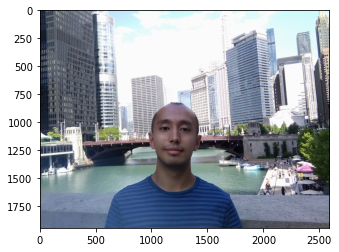

In [ ]:
prediction = np.argmax(model.predict(x))
print('The predicted emotion is : ' + label_dict[prediction])
my_image = image.load_img(img_path)
plt.imshow(my_image)